## Statystyka i procesy stochastyczne, Ćw. proj., grupa 4 


* Wojciech Pełka
* Konrad Stalmach
* Filip Stolarczyk
* Hubert Sujka


## Wstęp
Celem naszej pracy było zbadanie rozkładu liczby zgłoszeń do dowolnego serwera w ciągu minuty, narysowanie dystrybuanty empirycznej oraz sprawdzenie czy jest to proces Poissona.

Proces Poissona to rodzina (będąca procesem stochastycznym, zliczeniowym) $ ( N_{t} ,\;t\geq 0) $ zdefiniowana w następujący sposób:

$ N_{t}={\begin{cases}0,&X_{1}>t\\\sup\{n:X_{1}+\dots +X_{n}\leq t\},&X_{1}\leq t\end{cases}}. $

Gdzie ciąg ${\displaystyle (X_{i})_{i=1,2,3...}}$ jest ciągiem niezależnych zmiennych losowych o rozkładzie wykładniczym z jednakowym dla każdej ze zmiennych parametrem ${\displaystyle \lambda .}$

Zmienna ${\displaystyle X_{i}}$ oznacza czas pomiędzy (i-1)-szym a i-tym zdarzeniem (tradycyjnie nazywanym zgłoszeniem), a ${\displaystyle N_{t}}$ to liczba zgłoszeń, które wystąpiły do chwili t.

## Przebieg zadania

By zrealizować zadanie musieliśmy skonstruować funkcje przygotowujące dane do analizy. W celach analizy skorzystaliśmy ze zbioru danych z serwera Apache. Następnie narysowaliśmy wykresy dla danego przypadku, a na koniec dopasowaliśmy parametry do krzywej opisanej rozkładem Poissona.

Projekt zdecydowaliśmy się wykonać w aplikacji Jupyter Notebook w języku Python, ze względu na szeroki wybór bibliotek, które w prosty sposób pozwoliły zautomatyzować proces analizy.

## Predefiniowane funkcje przygotowujace dane do analizy:

Importujemy potrzebne biblioteki i zapobiegamy wyświetlaniu niepotrzebnych błędów

In [61]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython.core.display import display
from scipy.optimize import curve_fit
from scipy.special import factorial
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

Definujemy funkcje wyciagające przetwarzające łańcuchy znaków niezbędne do utworzenia interesujących nas kolumn:

In [62]:
#funkcje pomocnicze
def take_n_split(string,delimiter,pos):
    s=string.split(delimiter)
    
    number=list(s[pos])
    
    if number[0]=='0':
        return int(number[1])
    else:
        return int(number[0]+number[1])
def select_minute(data,minute):
    return data.loc[data['Minutes'] == minute]
def select_hour(data,hour):
    return data.loc[data['Hours'] == hour]

Tworzymy funkcję filtrującą dane. Wybieramy tylko takie minuty, w których liczba logów jest wieksza od 10,
aby można było łatwiej i dokładniej dopasować parametry rozkładu. Przy zbyt małej ilosci danych moga pojawić się problemy operacji w realizowanej przez funkcję:
curve_fit  z biblioteki scipy.optimize której uzywamy do dopasowania krzywej rozkładu.


In [63]:
def select_time_data(data,hour,minute):
    new_data=data

    new_data['in_minute']=new_data['Minutes'].apply(lambda x: x==minute)
    new_data['in_hour']=new_data['Hours'].apply(lambda x: x==hour)
    
   
    
    new_data=new_data.loc[(new_data['in_minute'] == True) & (new_data['in_hour']==True)] 
    data_out=pd.DataFrame({'Hours':new_data['Hours'], 'Minutes':new_data['Minutes'],'Seconds':new_data['Seconds']})
    
    
    
    return data_out, len(data_out)


In [64]:
def time_no_empty(df):
    df['Minutes']=df['Time'].apply(lambda x: take_n_split(x,':',2))
    df['Seconds']=df['Time'].apply(lambda x: take_n_split(x,':',3))
    df['Hours']=df['Time'].apply(lambda x: take_n_split(x,':',1))
    df["Enough"]=pd.Series([False]*len(df))
    
    for h in range(24):
        dfh=df.loc[df["Hours"]==h]
        for min in range(1,60):
            nr_events_per_minute=len(dfh.loc[(df['Minutes']==min) & (dfh['Hours']==h)])
            if nr_events_per_minute>10:
                for i in df.loc[(df['Minutes']==min) & (df['Hours']==h)].index:
                    df.at[i,"Enough"]=True
                
               
    df=df.loc[df['Enough']==True]
    
    data=pd.DataFrame({'Hours':df['Hours'],'Minutes':df['Minutes'],'Seconds':df['Seconds']})
    
    return data


Poniżej przedstawiamy częśc danych ze zbioru danych z serwera Apache z których korzystaliśmy:

In [65]:
data=(pd.read_csv('weblog.csv').head(30))
data


,IP,Time,URL,Staus
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200
5,10.130.2.1,[29/Nov/2017:06:59:19,GET /profile.php?user=bala HTTP/1.1,200
6,10.128.2.1,[29/Nov/2017:06:59:19,GET /js/jquery.min.js HTTP/1.1,200
7,10.131.2.1,[29/Nov/2017:06:59:19,GET /js/chart.min.js HTTP/1.1,200
8,10.131.2.1,[29/Nov/2017:06:59:30,GET /edit.php?name=bala HTTP/1.1,200
9,10.131.2.1,[29/Nov/2017:06:59:37,GET /logout.php HTTP/1.1,302


Stwórzmy funkcję, która zwraca dane dla zadanej daty, oraz liczbę rekordów. 

Ze zbioru danych z serwera Apache wybrano te minuty w których liczba logów jest większa od 10.

Takich przypadków były 2.
    


## Dla każdego z przypadków narysowano odpowiednie wykresy :
1. Liczba logów na sekundę
2. Prawdopodobieństwo wystapienia logu w danej sekundzie
3. Dystrybuanta Empiryczna rozkładu prawdopodobieństwa

## Następnie dokonano próby dopasowania parametrów rozkładu do parametrów krzywej opisanej rozkładem Poissona danego wzorem: 
$${P\left( x \right) = \frac{{e^{ - \lambda } \lambda ^x }}{{x!}}}$$

Wyniki dla godziny 13:38

Tabela czasowa:
Wyniki dla godziny 14:33

Tabela czasowa:


,Hours,Minutes,Seconds
15,13,38,3
16,13,38,4
17,13,38,7
18,13,38,19
19,13,38,20
20,13,38,20
21,13,38,20
22,13,38,20
23,13,38,20
24,13,38,20


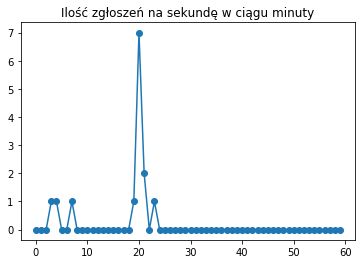

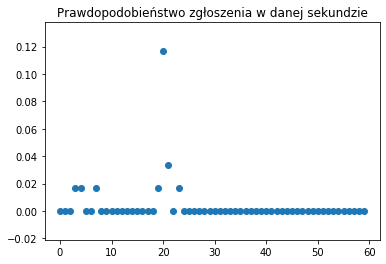

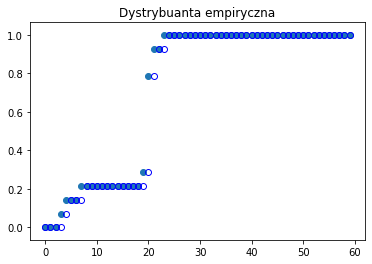

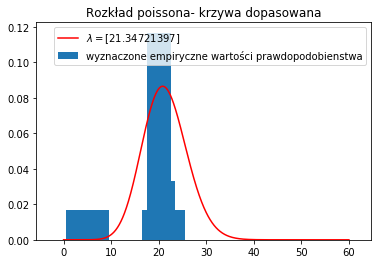

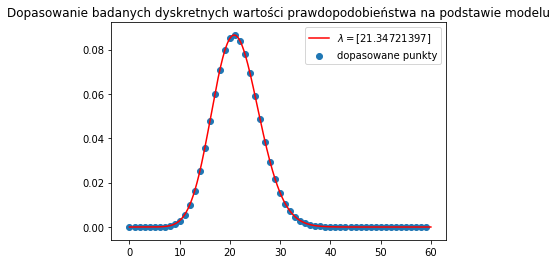

,Hours,Minutes,Seconds
63,14,33,21
64,14,33,22
65,14,33,22
66,14,33,22
67,14,33,22
68,14,33,22
69,14,33,23
70,14,33,23
71,14,33,23
72,14,33,23


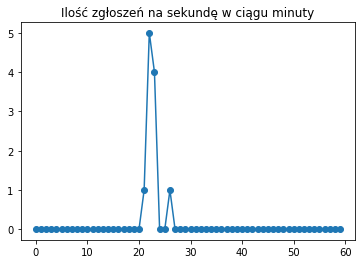

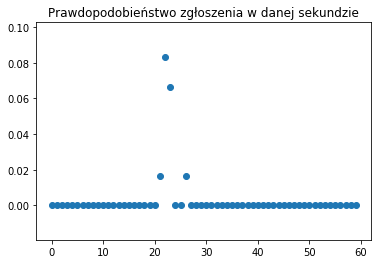

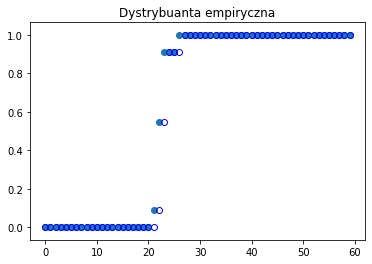

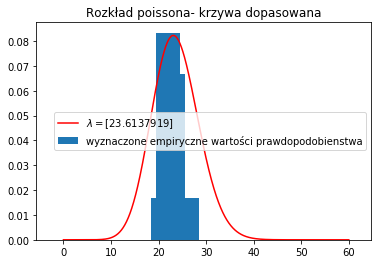

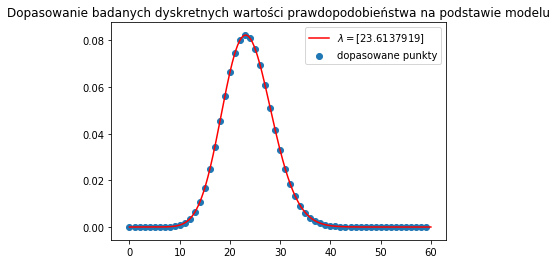

In [66]:

data=time_no_empty(pd.read_csv('weblog.csv').head(100))
hours=set(data['Hours'])
for hour in hours:
    minutes=set(data.loc[data['Hours']==hour]['Minutes'])
    for minute in minutes:
        
        selected_minute_data,nr_events=select_time_data(data,hour,minute)
        
        logs_per_second=[]
        for i in range (60):
            in_minute=selected_minute_data.apply(lambda x: x['Seconds']==i,axis=1)
            n_logs=len(in_minute[in_minute==True].index)
            logs_per_second.append([i,n_logs])
            
        print(f"Wyniki dla godziny {hour}:{minute}")
        print("")
        print("Tabela czasowa:")
        
        display(selected_minute_data)
        ax=plt.figure()
        plt.scatter(np.array(logs_per_second)[:,0],np.array(logs_per_second)[:,1])
        plt.plot(np.array(logs_per_second)[:,0],np.array(logs_per_second)[:,1])
        plt.title("Ilość zgłoszeń na sekundę w ciągu minuty")
        plt.show()
        
      
        
        #%%
        
        lps=np.array(logs_per_second)
        prob_lps=[i/len(lps) for i in lps[:,1]]
        
        fig=plt.figure()
        plt.scatter(lps[:,0],prob_lps)
        plt.title("Prawdopodobieństwo zgłoszenia w danej sekundzie")
        plt.show()
        
        
        #%%
        
        # dystrybuanta
        distribution=[]
        dist2=[0]
        distribution.append(logs_per_second[0])
        for i in range(1,len(logs_per_second)):
        
            distribution.append([i,distribution[i-1][1]+logs_per_second[i][1]/nr_events])
            dist2.append(distribution[i-1][1])
        ax2=plt.figure()
        dist=np.array(distribution)
        #plt.plot(dist[:,0],dist[:,1])
        plt.scatter(dist[:,0],dist[:,1])
        d=np.array(dist2)
        
        plt.plot(dist[:,0],d,'bo',mfc='none')
        plt.title("Dystrybuanta empiryczna")
        plt.show()
        
        
        #%%
        
        def poisson(k, lamb):
            return (lamb ** k / factorial(k)) * np.exp(-lamb)
        
        
        # fit with curve_fit
        
        try:       
        
            parameters, cov_matrix = curve_fit(poisson, lps[:, 0], prob_lps)
        
        
        
            ax = plt.gca(title='Rozkład poissona- krzywa dopasowana')
            x = np.linspace(0, 60, 1000)
            
            ax.plot(x, poisson(x, parameters),'r',label=f"$\lambda = {parameters}$")
            ax.bar(lps[:,0],prob_lps,width=5,label='wyznaczone empiryczne wartości prawdopodobienstwa')
            
            ax.legend()
            plt.show()
            ax2 = plt.gca(title='Dopasowanie badanych dyskretnych wartości prawdopodobieństwa na podstawie modelu')
            x = np.linspace(0, 60, 1000)

            ax2.plot(x, poisson(x, parameters),'r',label=f"$\lambda = {parameters}$")
            ax2.scatter(lps[:,0],poisson(lps[:,0],parameters),label='dopasowane punkty')

            ax2.legend()
            plt.show()
        except RuntimeError:  
            print('Rozklad nie jest rozkaldem Poissona')
            
            
            


Wyniki dla godziny 13

Tabela czasowa:
Wyniki dla godziny 14

Tabela czasowa:


,Hours,Minutes,Seconds
15,13,38,3
16,13,38,4
17,13,38,7
18,13,38,19
19,13,38,20
20,13,38,20
21,13,38,20
22,13,38,20
23,13,38,20
24,13,38,20


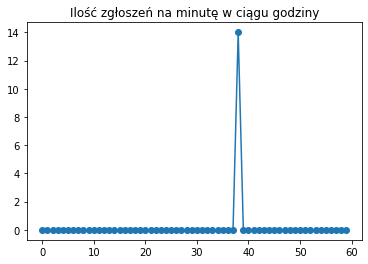

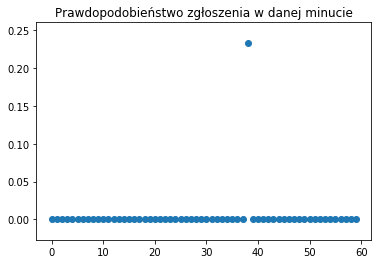

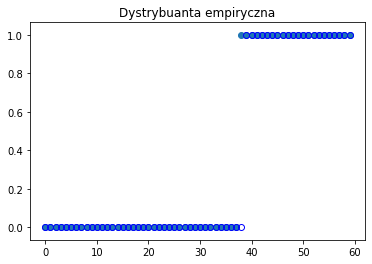

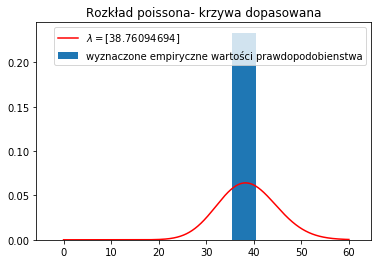

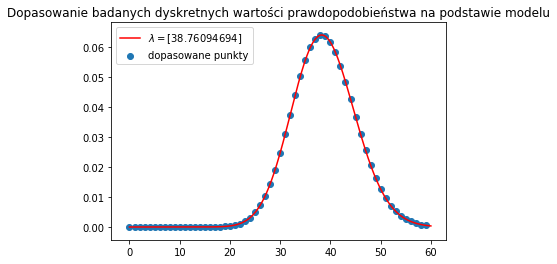

,Hours,Minutes,Seconds
63,14,33,21
64,14,33,22
65,14,33,22
66,14,33,22
67,14,33,22
68,14,33,22
69,14,33,23
70,14,33,23
71,14,33,23
72,14,33,23


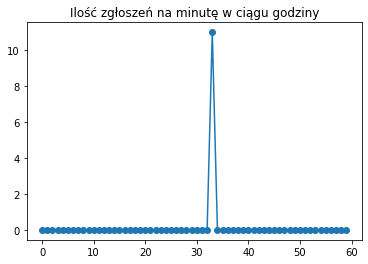

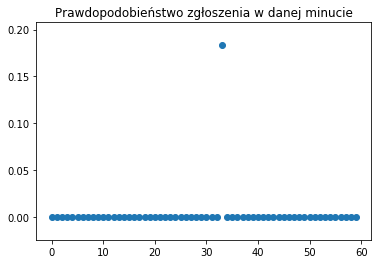

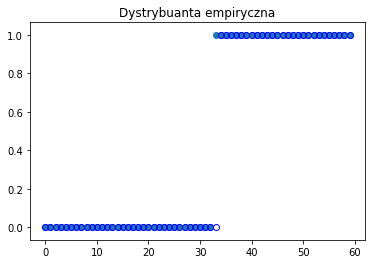

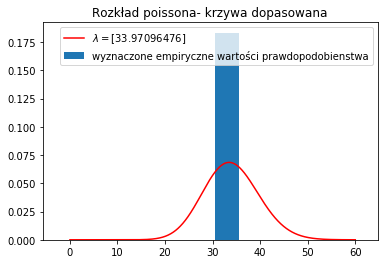

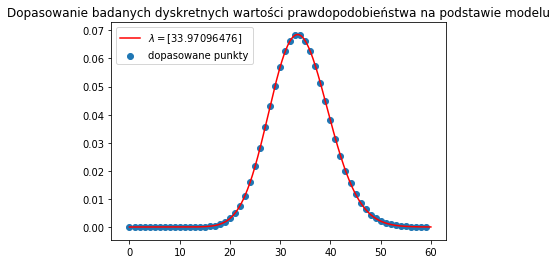

In [67]:
data=time_no_empty(pd.read_csv('weblog.csv').head(100))
hours=set(data['Hours'])
for hour in hours:
    minutes=set(data.loc[data['Hours']==hour]['Minutes'])
    for minute in minutes:
        
        selected_minute_data,nr_events=select_time_data(data,hour,minute)
        
        logs_per_second=[]
        for i in range (60):
            in_minute=selected_minute_data.apply(lambda x: x['Minutes']==i,axis=1)
            n_logs=len(in_minute[in_minute==True].index)
            logs_per_second.append([i,n_logs])
            
        print(f"Wyniki dla godziny {hour}")
        print("")
        print("Tabela czasowa:")
        
        display(selected_minute_data)
        ax=plt.figure()
        plt.scatter(np.array(logs_per_second)[:,0],np.array(logs_per_second)[:,1])
        plt.plot(np.array(logs_per_second)[:,0],np.array(logs_per_second)[:,1])
        plt.title("Ilość zgłoszeń na minutę w ciągu godziny")
        plt.show()
               #%%
        
        lps=np.array(logs_per_second)
        prob_lps=[i/len(lps) for i in lps[:,1]]
        
        fig=plt.figure()
        plt.scatter(lps[:,0],prob_lps)
        plt.title("Prawdopodobieństwo zgłoszenia w danej minucie")
        plt.show()
        
        
        #%%
        
        # dystrybuanta
        distribution=[]
        dist2=[0]
        distribution.append(logs_per_second[0])
        for i in range(1,len(logs_per_second)):
        
            distribution.append([i,distribution[i-1][1]+logs_per_second[i][1]/nr_events])
            dist2.append(distribution[i-1][1])
        ax2=plt.figure()
        dist=np.array(distribution)
        #plt.plot(dist[:,0],dist[:,1])
        plt.scatter(dist[:,0],dist[:,1])
        d=np.array(dist2)
        
        plt.plot(dist[:,0],d,'bo',mfc='none')
        plt.title("Dystrybuanta empiryczna")
        plt.show()
        
        
        #%%
        
        def poisson(k, lamb):
            return (lamb ** k / factorial(k)) * np.exp(-lamb)
        
        
        # fit with curve_fit
        
        try:       
        
            parameters, cov_matrix = curve_fit(poisson, lps[:, 0], prob_lps)
        
        
            ax = plt.gca(title='Rozkład poissona- krzywa dopasowana')
            x = np.linspace(0, 60, 1000)
            
            ax.plot(x, poisson(x, parameters),'r',label=f"$\lambda = {parameters}$")
            ax.bar(lps[:,0],prob_lps,width=5,label='wyznaczone empiryczne wartości prawdopodobienstwa')
            
            ax.legend()
            plt.show()

            ax2 = plt.gca(title='Dopasowanie badanych dyskretnych wartości prawdopodobieństwa na podstawie modelu')
            x = np.linspace(0, 60, 1000)

            ax2.plot(x, poisson(x, parameters),'r',label=f"$\lambda = {parameters}$")
            ax2.scatter(lps[:,0],poisson(lps[:,0],parameters),label='dopasowane punkty')

            ax2.legend()
            plt.show()
        except RuntimeError:
            print('Rozklad nie jest rozkaldem Poissona')
        except RuntimeError:  
            print('Rozklad nie jest rozkaldem Poissona')
            
            



**Wnioski:**


Celem naszej pracy było zbadanie liczby zgłoszeń do dowolnego serwera w ciągu minuty, narysować dystrybuantę empiryczną oraz sprawdzić czy jest to proces Poissona. 

Po opracowaniu danych, stwierdziliśmy, że jest to proces Poissona, ponieważ: $ N_{0} $ w czasie startowym ma wartość 0, przyrosty są niezależne oraz różnice między stanami mają  rozkład Poissona. 

Realizacja projektu umożliwiła nam na rozszerzenie naszych umiejętności w dziedzinie statystyki oraz poznanie nowych technik korzystania z wcześniej wymienionego języka.

Projekt został zrealizowany bez większych kłopotów, a wszystkie napotkane mniejsze problemy udało nam się rozwiązać poprzez dostępne materiały oraz wspólną komunikację.






  





